In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import scienceplots
plt.style.use(['science'])
plt.rcParams['text.latex.preamble'] = r'''
    \usepackage[T1]{fontenc}
    \usepackage{XCharter}
    \usepackage[charter,vvarbb,scaled=1.05]{newtxmath}
'''


from dynamic_tasker.access import *
from dynamic_tasker.orbits import *
from dynamic_tasker.constants import *
from dynamic_tasker.cameras import *
from dynamic_tasker.schedulers import *
from dynamic_tasker.rotations import *

%load_ext autoreload
%autoreload 2

In [2]:
# For diagram, have the spacecraft at the equator...

h = 400
t0 = datetime.datetime(2024, 1, 1, 12, 0, 0)
orbit = circular_orbit(a=Constants.R_E+h, i=np.deg2rad(0), Omega=np.pi, M=np.pi/2, t=t0)
field_of_regard = 45
N_points = 1000

# Get orbit in ECI so we can plot the other stuff
r = np.array([0, -(Constants.R_E + h), 0])


In [3]:
def roll2spherical_angle(angle, h):
    R = Constants.R_E
    theta = np.radians(angle)
    return np.sign(theta) * np.arccos(((R + h) * (np.sin(theta)) ** 2 + np.cos(theta) * np.sqrt(R**2 - ((R + h)**2) * (np.sin(theta) ** 2)))/(R))


def roll2crosstrack(angle, h):
    return Constants.R_E * roll2spherical_angle(angle, h)

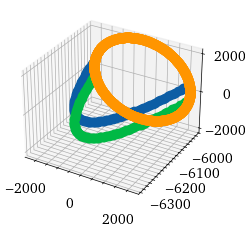

In [4]:
# Now calculate all relevant points in ECI...

for_spherical = np.degrees(roll2spherical_angle(field_of_regard, h))
for_dist = np.sin(np.radians(for_spherical)) * (Constants.R_E)
for_radius = np.cos(np.radians(for_spherical)) * (Constants.R_E)

# Now generate the points...
angle = np.linspace(0, 2*np.pi, N_points)
points_for_left = np.array([for_radius * np.cos(angle), for_radius * np.sin(angle), for_dist * np.ones(N_points)]).T
points_for_right = np.array([for_radius * np.cos(angle), for_radius * np.sin(angle), -for_dist * np.ones(N_points)]).T

# Calculate the horizon points...
horizon_angle = horizon_spherical_angle(orbit)
horizon_dist = np.cos(horizon_angle) * (Constants.R_E)
horizon_radius = np.sin(horizon_angle) * (Constants.R_E)
horizon_l2_dist = horizon_distance(orbit)

# Now generate the points...
angle = np.linspace(0, 2*np.pi, N_points)
points_horizon = np.array([horizon_radius * np.cos(angle), -horizon_dist * np.ones(N_points), horizon_radius * np.sin(angle)]).T

filtered_points_for_left = np.array([p for p in points_for_left if dist(p, r) < horizon_l2_dist])
filtered_points_for_right = np.array([p for p in points_for_right if dist(p, r) < horizon_l2_dist])

# Now plot the points in 3D...
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(filtered_points_for_left[:, 0], filtered_points_for_left[:, 1], filtered_points_for_left[:, 2], 'o')
ax.plot(filtered_points_for_right[:, 0], filtered_points_for_right[:, 1], filtered_points_for_right[:, 2], 'o')
ax.plot(points_horizon[:, 0], points_horizon[:, 1], points_horizon[:, 2], 'o')


# Set the view
# ax.view_init(elev=0, azim=90)
plt.show()

[    0 -6778     0]


/Users/shreeyam/phd_code/src/dynamic_tasker/cameras.py:27: RuntimeWarning: divide by zero encountered in matmul
  points = (P @ points.T).T
/Users/shreeyam/phd_code/src/dynamic_tasker/cameras.py:27: RuntimeWarning: overflow encountered in matmul
  points = (P @ points.T).T
/Users/shreeyam/phd_code/src/dynamic_tasker/cameras.py:27: RuntimeWarning: invalid value encountered in matmul
  points = (P @ points.T).T


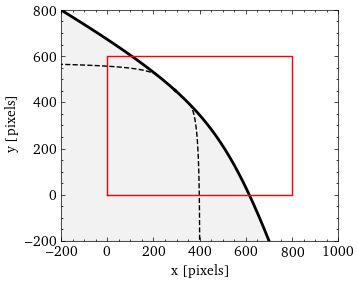

In [5]:
# Now projects the points to camera view
plt.figure(figsize=(4, 3))
rolldeg = 45
pitchdeg = 55
K = get_intrinsics(f=400, c_x=800/2, c_y=600/2)
R = eul2R(np.pi/2 + np.deg2rad(rolldeg),-np.deg2rad(pitchdeg), np.pi/2)
P = get_camera_matrix(K, R, r)


print(r)
camera_points_for_left = project(P, filtered_points_for_left, z_clip=True)
camera_points_for_right = project(P, filtered_points_for_right, z_clip=True)
camera_points_horizon = project(P, points_horizon)

plt.plot(camera_points_for_left[:, 0], camera_points_for_left[:, 1], 'k--')
plt.plot(camera_points_for_right[:, 0], camera_points_for_right[:, 1], 'k--')
plt.plot(camera_points_horizon[:, 0], camera_points_horizon[:, 1], 'k-', linewidth=2)
# Sort horizon points by x for proper fill
sorted_idx = np.argsort(camera_points_horizon[:, 0])
horizon_x = camera_points_horizon[sorted_idx, 0]
horizon_y = camera_points_horizon[sorted_idx, 1]

# Fill below the horizon (Earth, blue)
# plt.fill_between(
#     horizon_x,
#     horizon_y,
#     1000,  # bottom of the plot (downward, assuming image height is 600)
#     color='black',
#     alpha=0.5
# )

# Fill above the horizon (black, space)
plt.fill_between(
    horizon_x,
    -200,  # top of the plot (upward)
    horizon_y,
    color='black',
    alpha=0.05
)


box = create_box(800, 600, points_per_edge=2)
plt.plot(box[:, 0], box[:, 1], 'r-')
plt.xlim(-200, 1000)
plt.ylim(-200, 800)
plt.gca().set_aspect('equal')
plt.xlabel("x [pixels]")
plt.ylabel("y [pixels]")
plt.savefig(f"fli_constraints_camera_roll{rolldeg}.pdf")
plt.show()

# Now plot the camera view in 2D